## Business Objective

### Objective Function

Our objective in building this recommendation system is to provide our customers with personalized movie recommendations to keep them content and engaged with the platform, and likely to share this platform with their family and friends. In keeping current customers happy, we can optimize revenue from current plus the new customers they bring in. In a competitive, global, digital marketplace, having a superior movie recommendation system is a difference maker. 

### Framework

We wish to optimize our accuracy, which will be measured primarily using root-mean square error (rmse), and thus we will be performing our methods on a sampled dataset in order to test thoroughly and efficiently, sacrificing information that could be used to build and train our recommendation system.

Our intended users will be new, moderate, and avid users, who will be determined based on a threshold number of movies watched and rated on the platform. Providing recommendations for all different types of users is key into optimizing revenue and user experience for our company. The existing users are active on the platform, and thus, due to the high amount of information we have from them, we can also provide an accurate recommendation list for these users, leading to more trust from these customers in our platform. On the other hand, though new users may not have interacted with our platform as much, providing reliable recommendations will encourage these new users to use the platform even more and become avid users. Moderate users are those who have watched a certain number of movies to not be considered new, but do not use the platform as actively as the avid users. The purpose of our model is to encourage all different types of users to use the platform more increasing revenue for us and enhancing user experience, which will lead to more advertisement of our platform and what we provide. But in order to recommend good movies for each type of user, a different model must be used for each to provide the most accurate recommendations. 

Some business rules that we are considering while recommending movies are to only recommend movies with a certain threshold popularity, which will also be specified later. Since our target for this recommendation problem is focused on all types of users, we believe it is more suitable to have a separate model to work with each type of user. In addition, our list of recommendations will contain movies that have an average rating above a specific threshold, because we do not want to recommend movies that while popular, are not good movies. Customer satisfaction is our number one priority, and our recommended movies serve to provide customers with movies they can enjoy.

The structure of this report is as follows: the dataset is first sampled such that it abides by certain thresholds. Each model for the specific user category is built, explored, and optimized. The deep learning model is thoroughly explored in another file. Lastly, the final hybrid model is outlined and evaluated. Analyses and observations are made throughout the notebook with a final recommendation at the end. 

#### Libraries and Packages

In [2]:
import os
import math
import time
import scipy
import random
import findspark
import numpy as np
import pandas as pd
from surprise import Reader
from pyspark.sql import Row
from surprise import Dataset
from tensorflow import keras 
from surprise import KNNWithMeans
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from pyspark.context import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql.session import SparkSession
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise.model_selection.validation import cross_validate
os.environ['PYSPARK_PYTHON'] = '/Users/nehapusarla/anaconda3/bin/python3.7'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/Users/nehapusarla/anaconda3/bin/python3.7'

In [3]:
file = "../ratings.csv"

In [4]:
movie_file = "../ml-latest/movies.csv"

## Exploratory Data Analysis and Sampling

In [5]:
data = pd.read_csv(file)

In [6]:
data = data.drop(columns=['timestamp'])
data.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [6]:
user_df = data.groupby('userId').count()[['movieId']].rename(columns={'movieId':'ratings_count'})
user_df.head()

,ratings_count
userId,
1,16
2,15
3,11
4,736
5,72


In [169]:
avg_rating = data.groupby('userId').mean()['rating']
user_df['average_rating'] = avg_rating
user_df = user_df.reset_index()
user_df.head()

,userId,ratings_count,average_rating
0,1,16,3.312500
1,2,15,3.666667
2,3,11,3.545455
3,4,736,3.397418
4,5,72,4.263889


In [170]:
print("Number of users:", len(user_df))

Number of users: 283228


In [171]:
movie_df = data.groupby('movieId').count()[['userId']].rename(columns={'userId':'ratings_count'})
movie_df.head()

,ratings_count
movieId,
1,68469
2,27143
3,15585
4,2989
5,15474


In [172]:
avg_movie_rating = data.groupby('movieId').mean()['rating']
movie_df['average_movie_rating'] = avg_movie_rating
movie_df = movie_df.reset_index()
movie_df.head()

,movieId,ratings_count,average_movie_rating
0,1,68469,3.886649
1,2,27143,3.246583
2,3,15585,3.173981
3,4,2989,2.874540
4,5,15474,3.077291


In [174]:
print("Number of movies: ", len(movie_df))

Number of movies:  53889


From observing the data, we see there are 283,228 unique users and 53889 unique movies. We will want to train our model on at least 20,000 users and 1,000 movies. Hence we will set conditions based on our business objectives to narrow down our selection before randomly sampling to a smaller dataset.

### Finding Sampling Thresholds

To sample the dataset, we took some rules that we mentioned above under Framework into consideration. We mentioned that our intended user is all types of users. Therefore, the first step to sampling our dataset is to find the threshold of the number of movies that distinguishes a new, moderate, and active user. 

In [175]:
user_df.head()

,userId,ratings_count,average_rating
0,1,16,3.312500
1,2,15,3.666667
2,3,11,3.545455
3,4,736,3.397418
4,5,72,4.263889


In [5]:
#Split up into new users, moderate users, heavy users
user_df = data.groupby('userId').count()[['movieId']].rename(columns={'movieId':'ratings_count'})
print("33% percentile:", np.percentile(user_df['ratings_count'], 33))
print("66% percentile:", np.percentile(user_df['ratings_count'], 66))
user_df['ratings_count'].describe()

33% percentile: 17.0
66% percentile: 61.0


count    283228.000000
mean         97.989761
std         212.760722
min           1.000000
25%          15.000000
50%          30.000000
75%          95.000000
max       23715.000000
Name: ratings_count, dtype: float64

The $33^{rd}$ percentile of the number of movies each user rated is at 17, and therefore we are setting new users to those who have rated between 1 and 17 movies. The $66^{th}$ percentile is at 61, making moderate users those who have rated between 18 and 61 movies. Active users will be those in the dataset that have rated greater than 61 movies. 

In addition, we mentioned that we want to recommend good movies to our customers. Our analyses of what is considered a "good" movie is going to be done here, although it will not be implemented while sampling the dataset, rather while extracting the top 10 movies to recommend to the customer

Text(0.5, 1.0, 'average ratings for users')

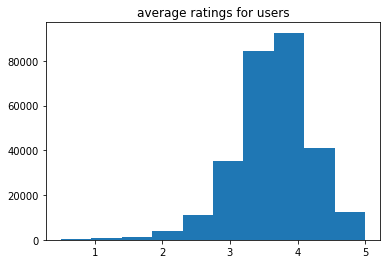

In [220]:
plt.hist(user_df['average_rating']);
plt.title("average ratings for users")

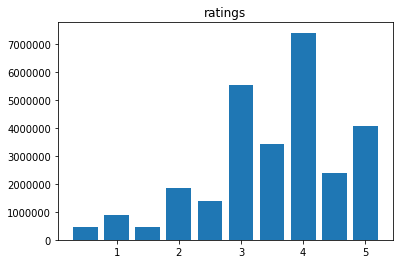

In [221]:
fig = plt.figure()
g = data.groupby('rating').count().reset_index();
x = g['rating']
y = g['userId']
plt.bar(x, y, width = 0.4);
plt.title("ratings");

In [222]:
data['rating'].describe()

count    2.775344e+07
mean     3.530445e+00
std      1.066353e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

The 2 plots are quite similar. We see through the bottom plots that more people give whole value numbers rather than halves. In addition, most people vote 4. The average rating given to a user is more normal. But similarly, most people's average ratings are around 3.5 to 4. Hence, when we determine whether or not a recommendation is "good", we will only consider values equal or greater than 3.5. This boundary will determine our accuracy in future parts of the project.

### Sampling

Read in the movie data

In [7]:
movies_data = pd.read_csv(movie_file)
movies_data.head() 

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


This method below finds the list of users that fall under the new, moderate, and active users category by splitting them up into three different dataframes based on the thresholds found above. For new users, we are subsetting the dataframe such that the users have at least 5 ratings in order to be able to hold out 20% of the data for testing. Therefore we will use users who have rated 5 to 17 movies for new users, 18 to 61 movies for moderate users, and greater than 62 movies for active users. In order to implement the dataset for our model, we took 7,000 users from each dataframe such that overall we will be testing on 21,000 users, and an equal amount of users from each category will have recommended movies. After finding 7,000 users from each user category, we split up the data into three different dataframes, keeping all the data for each user (ex: all 5 ratings for one user, or all 35 ratings for one user), such that we can keep the distinction between each user group.

In [9]:
def categorize_users(data):
    user_df = data.groupby('userId').count()[['movieId']].rename(columns={'movieId':'ratings_count'})
    
    new_users = user_df[user_df['ratings_count'] > 5]
    new_users = new_users[new_users['ratings_count'] <= 17].reset_index()['userId']
    mod_users = user_df[user_df['ratings_count'] > 17]
    mod_users = mod_users[mod_users['ratings_count'] <= 61].reset_index()['userId']
    active_users = user_df[user_df['ratings_count'] > 61].reset_index()['userId']
    
    new_users = new_users.sample(n=7000, random_state =1)
    mod_users = mod_users.sample(n=7000, random_state =1)
    active_users = active_users.sample(n=7000, random_state =1)
    
    new_users_data = data[data['userId'].isin(new_users)]
    mod_users_data = data[data['userId'].isin(mod_users)]
    active_users_data = data[data['userId'].isin(active_users)]
    
    return new_users_data, mod_users_data, active_users_data 

In [10]:
new_users_data, mod_users_data, active_users_data = categorize_users(data)

We are splitting each user category into 80/20 training and testing data, and then concatenating the training dataframes together and the testing dataframes together in order to create input for baseline models. The method in which we split train and test is very important for judging the plausibility of our model. Due to the nature of our recommendation system, we need to have the same users in both train and test. In addition, they need to have enough ratings for us to properly train and test our model.

In [11]:
y_new = new_users_data['rating']
x_new = new_users_data[[c for c in new_users_data.columns if c != 'rating']]
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(x_new, y_new, test_size=0.2, 
                            random_state = 1, stratify=new_users_data.userId)

y_mod = mod_users_data['rating']
x_mod = mod_users_data[[c for c in mod_users_data.columns if c != 'rating']]
mod_x_train, mod_x_test, mod_y_train, mod_y_test = train_test_split(x_mod, y_mod, test_size=0.2, 
                            random_state = 1, stratify=mod_users_data.userId)

y_active = active_users_data['rating']
x_active = active_users_data[[c for c in active_users_data.columns if c != 'rating']]
active_x_train, active_x_test, active_y_train, active_y_test = train_test_split(x_active, y_active, test_size=0.2, 
                            random_state = 1, stratify=active_users_data.userId)

#combine all user data to create one training and one testing dataframe 

new_training = pd.concat([new_x_train, new_y_train], axis=1)
new_testing = pd.concat([new_x_test, new_y_test], axis=1)
moderate_training = pd.concat([mod_x_train, mod_y_train], axis=1)
moderate_testing = pd.concat([mod_x_test, mod_y_test], axis=1)
active_training = pd.concat([active_x_train, active_y_train], axis=1)
active_testing = pd.concat([active_x_test, active_y_test], axis=1)


train = new_training.append([moderate_training, active_training])
test = new_testing.append([moderate_testing, active_testing])

In [32]:
print("Number of Users:", train['userId'].nunique())
print("Number of Movies:", train['movieId'].nunique() + test['movieId'].nunique())
print("Number of Ratings in Train:", len(train))
print("Number of Ratings in Test:", len(test))

Number of Users: 21000
Number of Movies: 40059
Number of Ratings in Train: 1616283
Number of Ratings in Test: 404072


As seen from this distribution above, we will be working with a total of **21,000** users and **40,059** movies. In addition, we will be training on a total of **1,616,283** ratings and testing on **404,072** ratings to evaluate our models. 

## Benchmarks 

### Evaluation Metrics

Our **primary** evaluation metric is RMSE. The RMSE is a quadratic scoring rule which measures the average magnitude of the error. RMSE reflects the squared difference between prediction and corresponding observed values which is then averaged over the sample and then taken the square root of. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. For our movie ratings recommender model, we do not want large errors in our recommendations as this would render the model useless. Thus, we believe RMSE is a good metric because it highly penalizes large errors.

The **secondary** evaluation metric is the ranking metric: precision and recall @ k. Precision measures the truly relevant recommendations out of everything recommended. Recall represents the truly relevant recommendations out of all relevant items. We are measuring these values at the top 10 recommendations for each user. Precision is a good evaluation metric for movie recommendations because the cost of a false positive is very high and the cost of a false negative is low. We do not want to give a wrong strong recommendation for a movie, that would be worse than missing a good movie to recommend. We consider a rating of 3.5 and above to be a "good" rating. From the analyses done in our exploratory section, we determine that majority of the ratings are around 3-4, with around the top 25% of the ratings 4 or higher. Therefore, for users to consider a movie good, or one of the top movies out of the movies they've rated, we set the cutoff at 3.5 to distinguish it as good. From previous testing, we notice that setting a cutoff of 4 was too stringent and we would not recommend enough "good" movies. Hence, we think that 3.5 would be more suitable.

The **third** evaluation metric is user/item coverage @ k. For user coverage, it was defined as the percentage of users in the test set that had all their items in the top-10 recommended items given by the algorithm. For item coverage, it was defined as the percentage of items in the training set that was actually recommended to users in the test set.


Our **fourth** evaluation metric is NDCG. DCG, or discounted cummulative gain, measures the relevance of an item based on its position in the results. The gain is highest at the top of the results list, where the gain continues to get discounted at every lower rank. IDCG, or ideal discounted cummulative gain, is found by producing the maximum possible DCG for each user. Therefore, NDCG, normalized discounted cummulative gain, is normalized across each user, meaning that the DCG is divided by the IDCG. The highest NDCG is 1, where the DCG is equal to the IDCG, and therefore the higher the NDCG, typically the better our ranking system is. 

### Baseline Model

Our baseline predicts a movie rating given by a user for a movie. That prediction is the average between 1) the average rating the user gives and 2) the average rating of a movie. Our reasoning behind this baseline is that most people have similar reactions to similar movies. If a movie is good, people will rate it highly and visa versa. In addition, we take into consideration how critical a user is. Some users may generally give lower ratings for movies and some higher. Therefore, our final prediction with our baseline is the average of these two values. We also included a caveat for situations where we do not have information about a movie's ratings in training due to the nature of splitting train and test data. In this situation, we will only judge based on the user's average rating. The way we split the data will not allow for there to be no user average rating so we do not need to consider this case. We believe this is a suitable baseline because most users are considered "normal" from our data exploration and will give similar ratings to similar movies.

In [12]:
def baseline_model(training, test):
    training = train.reset_index()
    test = test.reset_index()

    avg_movie_rating = training.groupby('movieId').mean().reset_index()[['movieId', 'rating']]
    avg_user_rating = training.groupby('userId').mean().reset_index()[['userId', 'rating']]
  
    pred = []
    for i in range(len(test)):
        user_id = test['userId'][i]
        movie_id = test['movieId'][i]
        user_avg = avg_user_rating[avg_user_rating['userId']==user_id]['rating'].iloc[0]

        temp = avg_movie_rating[avg_movie_rating['movieId'] == movie_id]
        if temp.empty:
            prediction = user_avg
        else:
            movie_avg = avg_movie_rating[avg_movie_rating['movieId'] == movie_id]['rating'].iloc[0]
            prediction = (user_avg + movie_avg) / 2

        pred.append(prediction)
        
    test['predictions'] = pred
    return test[['userId', 'movieId', 'rating', 'predictions']]

Use predictions on test dataset from this model for model evaluation.

In [15]:
baseline_preds = baseline_model(train, test)
baseline_preds['prediction'] = baseline_preds['predictions']
baseline_preds = baseline_preds.drop(columns=['predictions'])

### Evaluation

#### RMSE

In [16]:
def get_rmse(pred, original):
    rmse = (sum((pred-original)**2)/len(pred)) ** (1/2)
    return rmse

#additional error metric
def get_mae(pred, original):
    mae = sum(abs(original - pred)) / len(pred)
    return mae

In [17]:
rmse_base = get_rmse(baseline_preds['prediction'], baseline_preds['rating'])
print("RMSE for baseline:", rmse_base)

RMSE for baseline: 0.9209788487376078


#### Precision and Recall @ 10

In [18]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for index, row in predictions.iterrows(): 
        uid = row['userId']
        user_est_true[uid].append((row['prediction'], row['rating']))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [19]:
precisions_base, recalls_base = precision_recall_at_k(baseline_preds, k=10, threshold=3.5)
avg_base_precision = sum(precisions_base.values()) / len(precisions_base)
print("Average Precision @ 10:", avg_base_precision)
avg_base_recall = sum(recalls_base.values()) / len(recalls_base)
print("Average Recall @ 10:", avg_base_recall)

Average Precision @ 10: 0.6529291761148573
Average Recall @ 10: 0.5423348918724351


#### Coverage

In [21]:
def get_top_recs_cb(ratings, n):
    #returns the top n recommendations 
    top_recs = {}
    
    for index, row in ratings.iterrows():
        if row['userId'] not in top_recs.keys():
            top_recs[row['userId']] = [(row['movieId'], row['prediction'], row['rating'])]
        else:
            top_recs[row['userId']].append((row['movieId'], row['prediction'], row['rating']))
    
    # sort the preds for each user and get the n highest ones.
    for user, ratings in top_recs.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        top_recs[user] = ratings[:n]

    return top_recs

In [22]:
def user_coverage(top_recs, k):
    user_cov = {}
    tot = 0
    for user in top_recs:
        user_cov[user] = []
        for ratings in top_recs[user]:
            if ratings[2] >= 3.5:
                user_cov[user].append(ratings[0])
        if len(user_cov[user]) >= k:
            tot += 1
    return tot 

In [23]:
def item_coverage(top_recs, k):
    item_cov = {}
    tot = 0
    for user in top_recs:
        for ratings in top_recs[user]:
            if ratings[0] not in item_cov.keys(): 
                item_cov[ratings[0]] = [] 
            if ratings[2] >= 3.5:
                item_cov[ratings[0]].append(ratings[0])  
                
    for item in item_cov:
        if len(item_cov[item]) >= k:
            tot += 1        
    return tot, item_cov

In [24]:
toprecs_base_test = get_top_recs_cb(baseline_preds, 10)
user_cov_test_base = user_coverage(toprecs_base_test, 1) / len(toprecs_base_test)
print ("User Coverage of test set:", user_cov_test_base)
item_cov_ts_base, item_dict_ts_base = item_coverage(toprecs_base_test, 1)
item_cov_test_base = item_cov_ts_base / len(item_dict_ts_base)
print ("Item Coverage of test set:", item_cov_test_base)

User Coverage of test set: 0.9332857142857143
Item Coverage of test set: 0.8257609175121305


#### NDCG

In [25]:
def ndcg_at_k(predictions, k=10):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    ndcgs = [] 
    for index, row in predictions.iterrows(): 
        uid = row['userId']
        user_est_true[uid].append((row['prediction'], row['rating']))
        
    def dcg_at_k(user_ratings, user_preds, k=10):
        # Sort user ratings by estimated value
        user_preds = np.argsort(user_preds)[::-1]
        user_ratings = np.take(user_ratings, user_preds[:k])
        user_ratings = np.array(user_ratings)
        num = 2 ** user_ratings - 1
        den = np.log2(np.arange(2, num.size + 2))
        dcg = np.sum(num/den)
        return dcg
        
    for uid, scores in user_est_true.items():
        user_preds = [x[0] for x in scores]
        user_ratings = [x[1] for x in scores]
        dcg = dcg_at_k(user_ratings, user_preds)
        idcg = dcg_at_k(user_ratings, user_ratings)
        ndcg = dcg/idcg
        ndcgs.append(ndcg)
    
    avg_ndcg = sum(ndcgs)/len(ndcgs) 
    return avg_ndcg

In [26]:
avg_ndcg_base = ndcg_at_k(baseline_preds)
print("Average NDCG @ 10:", avg_ndcg_base)

Average NDCG @ 10: 0.8609242830244749


### Collaborative Filtering Baseline 

Another baseline that we are implementing to check our hybrid model against is the collaborative filtering baseline. Collaborative filtering works on past user behavior without any context so we think it would provide a valuable baseline for our other models. Our implementation of item based CF makes recommendations based on similarity between items calculated from user ratings of those items. We create the movie by movie matrix and predict the ratings a user will give a movie based on the previous ratings they have given. In addition, item based CF would be more suitable for our platform where the increase of new movies is much slower than the increase of new users. When we get a new user, we do not need to recalculate user to user similarity like we need for user based CF. This model is thoroughly explored in another file called *Item Based Collaborating Filtering and MF Exploration*, where we found that using a neighborhood size of k=50 would provide the best results, and therefore, used this optimized model to provide another benchmark.  

#### Item-Based CF Model

In [14]:
def get_model_ib(training_df, k):
    moviescales = Reader(rating_scale=(0.5, 5.0))
    data_training = Dataset.load_from_df(training_df[['userId', 'movieId', 'rating']], moviescales)    
    trainset = data_training.build_full_trainset()
    knn_model = KNNWithMeans(sim_options = {'name':'pearson', 'user_based': False}, k=k)
    knn_model.fit(trainset)
    return knn_model 

In [18]:
def get_predictions(model, test_df):
    preds = [] 
    for index, row in test_df.iterrows(): 
        pred = model.predict(row['userId'], row['movieId'], r_ui=row['rating'], verbose=False)
        preds.append(pred.est)
    
    return preds

Use predictions on test dataset from this model for model evaluation.

In [19]:
cf_model = get_model_ib(train, 50)
cf_preds = get_predictions(cf_model, test)

### Evaluation

#### RMSE

In [22]:
rmse_cf = get_rmse(cf_preds, test['rating'])
mae_cf = get_mae(cf_preds, test['rating'])
print("RMSE for test holdouts:", rmse_cf)
print("MAE for test holdoutes:", mae_cf)

RMSE for test holdouts: 0.8674876267450995
MAE for test holdoutes: 0.6578941565068348


#### Precision and Recall @ 10

In [24]:
cf_test_preds = test
cf_test_preds['prediction'] = cf_preds

In [27]:
precisions_cf, recalls_cf = precision_recall_at_k(cf_test_preds, k=10, threshold=3.5)
avg_cf_precision = sum(precisions_cf.values()) / len(precisions_cf)
print("Average Precision @ 10:", avg_cf_precision)
avg_cf_recall = sum(recalls_cf.values()) / len(recalls_cf)
print("Average Recall @ 10:", avg_cf_recall)

Average Precision @ 10: 0.6852053476945956
Average Recall @ 10: 0.5636736957710076


#### Coverage

In [33]:
toprecs_cf_test = get_top_recs_cb(cf_test_preds, 10)
user_cov_test_cf = user_coverage(toprecs_cf_test, 1) / len(toprecs_cf_test)
print ("User Coverage of test set:", user_cov_test_cf)
item_cov_ts_cf, item_dict_ts_cf = item_coverage(toprecs_cf_test, 1)
item_cov_test_cf = item_cov_ts_cf / len(item_dict_ts_cf)
print ("Item Coverage of test set:", item_cov_test_cf)

User Coverage of test set: 0.9333809523809524
Item Coverage of test set: 0.810377222141928


#### NDCG

In [178]:
avg_ndcg_cf = ndcg_at_k(cf_test_preds)
print("Average NDCG @ 10:", avg_ndcg_cf)

Average NDCG @ 10: 0.8723997488515359


## Content Based Model - New Users

We chose to use a content based model to provide top movie recommendations for the new user category, or more specifically those who have rated between 1 to 17 movies. For testing purposes, however, we increased the minimum number of ratings to 5 to create a viable train and test split. Given the fact that this category has limited information about the users and their preferences, we determined that a content based model would be the most appropriate as the model would focus on the content that the user has watched and liked/disliked previously, and try to recommend movies similar to the previous content. With this method, the model will not need data from any other users, and can recommend specific to user interest, optimizing the recommendations for users we do not have much information about. 

In this model, the user profile is a dataframe of the different features of the movies that the user has previously rated, where these features are extracted from using TF-IDF on the genres of each movie. The user profile is fed into a linear ridge regression model, such that the model is personalized for each user and can predict ratings for other unseen movies for that user. Another model approach that we considered implementing was finding the cosine similarity between the user and item profile, and returning the most similar movies as the top ten recommendations for the user. More description and an implementation of this alternate model is in the *Other_Baseline_Content_Based.ipynb* file under the src folder.

We decided to move forward with the first approach using linear regression instead because we believed it provide a more robust analysis and more accurate results for the new users. The linear regression model trains a separate model for each user such that it can take into account previous ratings for each movie rated, and predict more accurately. While the cosine similarity method may be faster, we believe its accuracy will pale in comparison with the linear regression approach we took. In addition, we talked to the professor and TA about the content based model approach and got conflicting advice on which approach we should move forward with, and therefore, stuck through with the model that we believed would recommend more accurately. This discussion can be referenced on Piazza (private question @116). 

#### Preprocessing

In the new user preprocessing method, we are taking in the new users data frame and splitting it into a train and test set that can be inputted into the model to make predictions. We split the data with an 80/20 split. In addition, this method takes in a movie data dataset, and converts its genres to a list of strings such that it can be correctly inputted into the TFIDF vectorizer. 

In [99]:
def new_user_preprocessing(new_user_data, movie_data):
    y_new = new_users_data['rating']
    x_new = new_users_data[[c for c in new_users_data.columns if c != 'rating']]
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(x_new, y_new, test_size=0.2, 
                                random_state = 1, stratify=new_users_data.userId)
    
    new_training = pd.concat([new_x_train, new_y_train], axis=1)
    new_testing = pd.concat([new_x_test, new_y_test], axis=1)
    
    movie_data['genres'] = movie_data['genres'].str.split('|')
    movie_data['genres'] = movie_data['genres'].fillna("").astype('str')
    
    return new_training, new_testing, movie_data

In [100]:
training_nu, test_nu, movie_data = new_user_preprocessing(new_training, movies_data)

### Model 

In [27]:
def content_based_model(movie_data, train, test, alpha):
    #item profile
    tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
    tf_matrix = tfidf.fit_transform(movie_data['genres'])
    tfidf_data = pd.DataFrame(tf_matrix.todense(), columns = tfidf.get_feature_names())
    tfidf_data = tfidf_data.set_index(movie_data['movieId'])
    
    visited_users = [] 
    movie_list = []
    preds = []
    original = [] 
    predicted_ratings = pd.DataFrame() 
    
    for user in test.userId.unique():
        if user in visited_users: 
            continue
        
        toPredict = test[test['userId'] == user]
        
        #user profile 
        ratings_user = train[train['userId'] == user]
        if ratings_user.empty:
            continue 
        
        user_genre = tfidf_data.loc[list(ratings_user['movieId'])]
        
        #build model for each user 
        reg = Ridge(alpha=alpha)
        reg.fit(user_genre, ratings_user['rating'])
        
        original = original + list(toPredict['rating'])
        visited_users = visited_users + ([user] * len(toPredict))
        movie_list = movie_list + list(toPredict['movieId'])
        #to_test = tfidf_data.loc[list(toPredict['movieId'])]
        predictions = list(reg.predict(tfidf_data.loc[list(toPredict['movieId'])])) 
        preds = preds + predictions
        
    predicted_ratings['userId'] = visited_users
    predicted_ratings['movieId'] = movie_list
    predicted_ratings['rating'] = original
    predicted_ratings['prediction'] = preds
    
    return predicted_ratings 

### Evaluation

### Cross-Validation

The RMSE is calculated as a **primary** metric to determine the best alpha for the model, and MAE is calculated to add any additional insight in the case that RMSE does not distinguish.

In [66]:
def cross_valid_cb(movie_data, folds, train, alpha):
    rmses = []
    maes = []
    split_ind = len(train) // folds 
    for i in range(1, folds+1):  
        test = train[((i-1)*split_ind):(i * split_ind)]
        training = pd.concat([train[:(i-1)*split_ind], train[i*split_ind:]])
        
        ratings = content_based_model(movie_data, training, test, alpha)
        rmse = get_rmse(ratings['prediction'], ratings['rating'])
        mae = get_mae(ratings['prediction'], ratings['rating'])
        
        rmses.append(rmse)
        maes.append(mae)
        
        
    avg_rmse = sum(rmses) / len(rmses)
    avg_mae = sum(maes) / len(maes)
    
    return avg_rmse, avg_mae

In [70]:
def hypertuning_cb(alphas, movie_data, folds, train):
    rmses = [] 
    maes = []
    for alpha in alphas: 
        rmse, mae = cross_valid_cb(movie_data, folds, train, alpha)
        rmses.append(rmse)
        maes.append(mae)
        
    return rmses, maes

In [71]:
alphas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

In [28]:
rmses, maes = hypertuning_cb(alphas, movie_data, 10, training_nu)

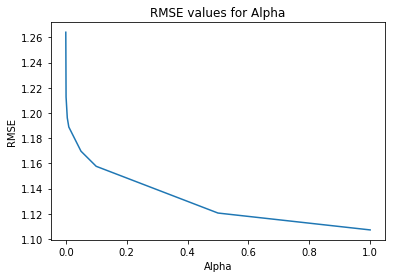

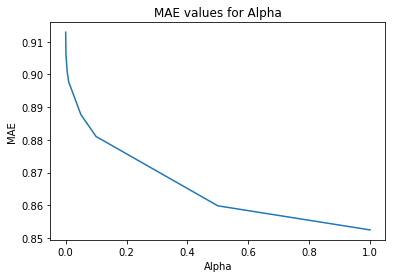

In [233]:
plt.figure()
plt.plot(alphas, rmses)
plt.title("RMSE values for Alpha")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.show()

plt.figure()
plt.plot(alphas, maes)
plt.title("MAE values for Alpha")
plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.show()

In [234]:
#get the min rmse value for alpha
rmse_min = 0
for i in range(len(rmses)):
    if rmses[i] < rmses[rmse_min]: 
        rmse_min = i
        
print("Alpha: " + str(alphas[rmse_min]) + ", RMSE: " + str(rmses[rmse_min]))

Alpha: 1, RMSE: 1.107108213817083


As seen from the plot above, the RMSE and MAE metric follow similar patterns. There is a significant increase in accuracy between as the alpha value increases. After finding the minimum RMSE value, we determined that setting the hyper-parameter to alpha=1 will be the best to proceed the rest of our model evaluations with.

We calculated the MAE pattern as well to enforce our reasoning for choosing alpha=1. MAE also has the best accuracy at around alpha=1.

### Accuracy Metrics

We will use the results from this model run in order to evaluate our accuracy metrics. 

In [29]:
#model predictions
predicted_ratings = content_based_model(movie_data, training_nu, test_nu, 1)

#### RMSE

In [102]:
rmse = get_rmse(predicted_ratings['rating'], predicted_ratings['prediction'])
mae = get_mae(predicted_ratings['rating'], predicted_ratings['prediction'])
print("RMSE for test holdouts:", rmse)
print("MAE for test holdoutes:", mae)

RMSE for test holdouts: 1.0703456104106734
MAE for test holdoutes: 0.8265421684282523


#### Precision and Recall @ 10

In [79]:
precisions_cb, recalls_cb = precision_recall_at_k(predicted_ratings, k=10, threshold=3.5)
avg_cb_precision = sum(precisions_cb.values()) / len(precisions_cb)
print("Average Precision @ 10:", avg_cb_precision)
avg_cb_recall = sum(recalls_cb.values()) / len(recalls_cb)
print("Average Recall @ 10:", avg_cb_recall)

Average Precision @ 10: 0.4447857142857143
Average Recall @ 10: 0.487


From our results above, the precision and recall for the top recs are relatively low. The low precision indicates that the recommendations our users recieve are not entirely relevant. The recall indicates there are still a good amount of unexplored relevant movies that our model does not capture. This can be explored further with analyses on novelty and serendipity.

#### Coverage

In [93]:
top_recs_cb_test = get_top_recs_cb(predicted_ratings, 10)
user_cov_test_cb = user_coverage(top_recs_cb_test, 1) / len(top_recs_cb_test)
print ("User Coverage of test set:", user_cov_test_cb)
item_cov_ts_cb, item_dict_ts_cb = item_coverage(top_recs_cb_test, 1)
item_cov_test_cb = item_cov_ts_cb / len(item_dict_ts_cb)
print ("Item Coverage of test set:", item_cov_test_cb)

User Coverage of test set: 0.771
Item Coverage of test set: 0.7733612273361228


#### NDCG

In [179]:
avg_ndcg_cb = ndcg_at_k(predicted_ratings)
print("Average NDCG @ 10:", avg_ndcg_cb)

Average NDCG @ 10: 0.9256853619795273


## Matrix Factorization - Moderate Users

We chose to use a matrix factorization model on moderate users, or more specifically those who have rated between 18 to 61 movies. Our matrix factorization model works by decomposing the user-item dataframe into the product of two lower dimensionality matrices. It discovers the latent factors from the user-item dataframe and uses these features to map the users and movies. We found this model to be most appropriate for moderate users as it is a collaborative filtering model and it can use the increased information from other users to evaluate its own predictions for the user. In addition, this method would not work well with new users because the matrix would be too spare to give a valid recommendation.

#### Preprocessing

In [82]:
findspark.init() 

In [83]:
sc = SparkContext('local')
spark = SparkSession(sc)

The moderate user preprocessing method drops the genres column from the moderate users dataframe because this information is not necessary for the model, and uses Spark to split the dataframe into an 80/20 training and testing split. 

In [106]:
def mod_user_preprocessing(mod_user_data):
    mod_data = mod_user_data[[c for c in mod_user_data.columns if c != 'genres']]
    ratings = spark.createDataFrame(mod_data)
    mod_training, mod_test = ratings.randomSplit([0.8, 0.2])
    return mod_training, mod_test 

In [109]:
mod_training, mod_test = mod_user_preprocessing(moderate_training)

### Model 

In [111]:
# Build the recommendation model using ALS on the training data
def mf_model(rank, regparam, training, testing):
    als = ALS(maxIter=5, rank=rank, regParam=regparam, userCol="userId", itemCol="movieId", ratingCol="rating",
              coldStartStrategy="drop")
    model = als.fit(training)
    predictions = model.transform(testing)
    mod_preds = predictions.select("*").toPandas()
    return mod_preds 

### Evaluation

The **primary** accuracy metric we are going to use to determine the best hyper-parameters for this model is the root mean squared error. This method optimizes the rank(number of latent factors) and regularization parameter because these are the two hyper-parameters that we are going to tune for the best results.

### Cross Validation

In [112]:
def build_crossvalid_mf(folds, ratings, regParam, rank): 
    rmses = [] 
    weights = [1.0] * folds
    sets = ratings.randomSplit(weights)
    #create new test and training data frames for each fold 
    for i in range(0, folds):  
        training = spark.createDataFrame(sc.emptyRDD(), ratings.schema)
        test = sets[i]
        for j in range(0, folds):
            if i != j: 
                training = training.union(sets[j])
        
        preds = mf_model(rank, regparam, training, test)
        rmse = get_rmse(preds['prediction'], preds['rating']) 
        rmses.append(rmse)
        
    avg_rmse = sum(rmses)/len(rmses)
    return avg_rmse

In [125]:
rank_range = [1,2,3,4,5,6,7,8,9,10,50,100] #latent dimensions 
reg_range = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.25] #regularization parameter 

Instead of testing on a range of values that increment by a certain constant, for example, from 2 to 100 in increments of 2, we specified our own ranges for the rank and regularization parameters to be tested on in order to provide results under certain time constraints. Because time was a factor in performing the tuning of the hyper-parameters, we believe that the ranges we outlined would provide us with enough information about the model.

In [126]:
def hypertuning_mf(ratings, rank_range, reg_range, folds):
    #hold one parameter constant by testing the range of the other parameter
    rmses_rank = {}
    for rank in rank_range: 
        rmse = build_crossvalid_mf(folds, ratings, 0.01, rank)
        print("Cross-validation done for rank:", rank)
        rmses_rank[rank] = rmse 
     
    rmses_reg = {}
    for reg in reg_range:
        rmse = build_crossvalid_mf(folds, ratings, reg, 10)
        print("Cross-validation done for reg:", reg)
        rmses_reg[reg] = rmse        
        
    return rmses_rank, rmses_reg

In order to tune two parameters within time contraints, we held one parameter constant while tuning the other hyper-parameter. While tuning rank, we set the regularization parameter to 0.01, and while tuning the regularization parameter, we set the rank to 10. Both of these parameters were set to the stated values because these values are the defaults that Spark uses when not specified.

In [252]:
rmses_rank, rmses_reg = hypertuning_mf(mod_training, rank_range, reg_range, 10)

Cross-validation done for rank: 1
Cross-validation done for rank: 2
Cross-validation done for rank: 3
Cross-validation done for rank: 4
Cross-validation done for rank: 5
Cross-validation done for rank: 6
Cross-validation done for rank: 7
Cross-validation done for rank: 8
Cross-validation done for rank: 9
Cross-validation done for rank: 10
Cross-validation done for rank: 50
Cross-validation done for rank: 100
Cross-validation done for reg: 0.0025
Cross-validation done for reg: 0.005
Cross-validation done for reg: 0.01
Cross-validation done for reg: 0.05
Cross-validation done for reg: 0.1
Cross-validation done for reg: 0.25


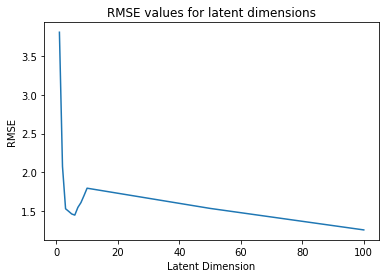

In [271]:
plt.figure()
plt.plot(rmses_rank.keys(), rmses_rank.values())
plt.title("RMSE values for latent dimensions")
plt.xlabel('Latent Dimension')
plt.ylabel('RMSE')
plt.show()

In [254]:
#get the min rmse value for rank 
rmse_min = list(rmses_rank.keys())[0]
for rank in rmses_rank: 
    if rmses_rank[rank] < rmses_rank[rmse_min]: 
        rmse_min = rank
        
print("Rank: " + str(rmse_min) + ", RMSE: " + str(rmses_rank[rmse_min]))

Rank: 100, RMSE: 1.2602148984529193


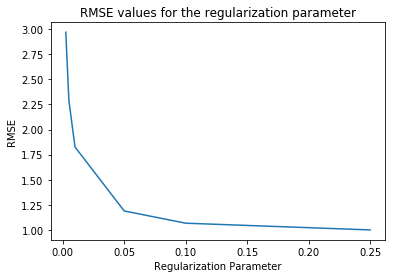

In [272]:
plt.figure()
plt.plot(rmses_reg.keys(), rmses_reg.values())
plt.title("RMSE values for the regularization parameter")
plt.xlabel('Regularization Parameter')
plt.ylabel('RMSE')
plt.show()

In [256]:
#get the min rmse value for reg 
rmse_min = list(rmses_reg.keys())[0]
for reg in rmses_reg: 
    if rmses_reg[reg] < rmses_reg[rmse_min]: 
        rmse_min = reg
        
print("Reg Param: " + str(rmse_min) + ", RMSE: " + str(rmses_reg[rmse_min]))

Reg Param: 0.25, RMSE: 0.9999413451244828


From the plots seen above, the RMSE values for the rank and regularization parameter appear to be following an approximate exponential distribution. As the value of the parameter increases, the RMSE greatly decreases, leaving the regularization parameter of 0.25 as having the minimum RMSE, and the rank of 100 has having the minimum RMSE. 

### Accuracy Metrics

We will use the results from this model run in order to evaluate our accuracy metrics.

In [87]:
mod_test_preds = mf_model(100, 0.25, mod_training, mod_test)

#### RMSE

In [113]:
rmse_test = get_rmse(mod_test_preds['prediction'], mod_test_preds['rating'])
print("RMSE:", rmse_test)

RMSE: 0.9889699092627541


#### Precision and Recall @ 10

In [114]:
precisions_mf, recalls_mf = precision_recall_at_k(mod_test_preds, k=10, threshold=3.5)
avg_mf_precision = sum(precisions_mf.values()) / len(precisions_mf)
print("Average Precision @ 10:", avg_mf_precision)
avg_mf_recall = sum(recalls_mf.values()) / len(recalls_mf)
print("Average Recall @ 10:", avg_mf_recall)

Average Precision @ 10: 0.57736344032854
Average Recall @ 10: 0.47159298752980355


The precision is relatively low, meaning that we were only able to recommend approximately a litte over half relevant movies out of the top 10 movies recommended. 

The low recall shows that we weren't able to predict as many good movies as the users rated. Recall is important because we want to continuously provide our users with good recommendations, so it is crucial to provide a sufficient list of good movies. If the number of good movies we recommend decreases, then the users may start to use the platform less.

#### Coverage

In [94]:
top_recs_test_mf = get_top_recs_cb(mod_test_preds, 10)
user_cov_test_mf = user_coverage(top_recs_test_mf, 1) / len(top_recs_test_mf)
print ("User Coverage of test set:", user_cov_test_mf)
item_cov_ts_mf, item_dict_ts_mf = item_coverage(top_recs_test_mf, 1)
item_cov_test_mf = item_cov_ts_mf / len(item_dict_ts_mf)
print ("Item Coverage of test set:", item_cov_test_mf)

User Coverage of test set: 0.9326507066628209
Item Coverage of test set: 0.8345646437994723


In [115]:
k = [1, 2, 3, 4, 5, 6, 7]
user_covs_test = []
item_covs_test = [] 

for num in k: 
    user_cov_test_mf = user_coverage(top_recs_test_mf, num) / len(top_recs_test_mf)
    user_covs_test.append(user_cov_test_mf)
    item_cov_ts_mf, item_dict_ts_mf = item_coverage(top_recs_test_mf, num)
    item_cov_test_mf = item_cov_ts_mf / len(item_dict_ts_mf)
    item_covs_test.append(item_cov_test_mf) 

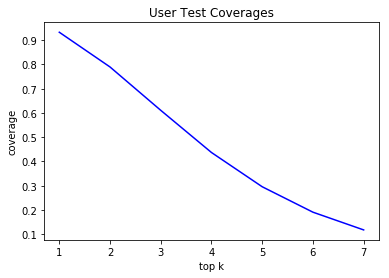

In [118]:
plt.figure()
plt.plot(k, user_covs_test, c="b")
plt.title("User Test Coverages")
plt.xlabel('top k')
plt.ylabel('coverage')
plt.show()

As expected, the user testing coverages decreased as we increased k. The user coverage is something to work on as our goal is to maintain the satisfaction of all of our users.

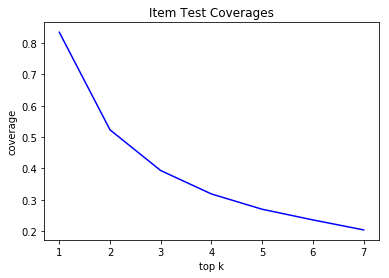

In [119]:
plt.figure()
plt.plot(k, item_covs_test, c="b")
plt.title("Item Test Coverages")
plt.xlabel('top k')
plt.ylabel('coverage')
plt.show()

The item coverage also decreases as k increases, and significantly drops from k=1 to k=2. 

#### NDCG

In [180]:
avg_ndcg_mf = ndcg_at_k(mod_test_preds)
print("Average NDCG @ 10:", avg_ndcg_mf)

Average NDCG @ 10: 0.9228266735530692


## Deep Learning Model - Active Users

We chose to use a deep learning model to provide movie recommendations for the active user category, or more specifically those who have rated more than 62 movies. Given that 7000 of the most active users total around 1.6 million movie ratings, we determined that a deep learning model would perform the best, as deep learning performance is known to scale well very well with large amounts of data. With this method, we can take advantage of the large amounts of ratings we have in this subset of users, optimizing the recommendations for users we have a lot of information on. In this model, the features consist of the user ID, movie ID, and the multi-label binarized version of the movie genres. The movie genre matrix becomes a very sparse categorical matrix, so we chose to implement a wide and deep model. The user IDs and movie IDS are passed into dense embedding layers, which are then concatenated and passed through deep dense layers. Finally, the output of the dense layers is concatenated with the wide genre features to make the final prediction. The model is optimized on various aspects, including embedding dimensions, number of dense layers, dropout, and learning rate to output the optimal predicted rating for users.

This model is thoroughly explored and evaluated in another file called: *DLExploration.ipynb*. Preprocessing steps for conversion of input to this model is outlined below. 

#### Preprocessing

In [166]:
def active_preprocessing(active_user_dataset, movies_data):
    merged=active_user_dataset.merge(movies_data).drop(['title'], axis=1)
    genres_encoder = MultiLabelBinarizer()
    merged['genres'] = genres_encoder.fit_transform(merged['genres'].apply(lambda s: s.split("|"))).tolist()
    merged[genres_encoder.classes_.tolist()] = pd.DataFrame(merged.genres.tolist(), index= merged.index)
    merged=merged.drop('genres',axis=1)
    
    user_enc = LabelEncoder()
    merged['user'] = user_enc.fit_transform(merged['userId'].values)
    item_enc = LabelEncoder()
    merged['movie'] = item_enc.fit_transform(merged['movieId'].values)
    merged['rating'] = merged['rating'].values.astype(np.float32)

    X = merged[[c for c in merged.columns if c!='rating']].values
    y = merged['rating'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=merged.user)

    X_train_array = [X_train[:, -2], X_train[:, -1], X_train[:, 2:-2]]
    X_test_array = [X_test[:, -2], X_test[:, -1], X_test[:, 2:-2]]
    
    return X_train_array, X_test_array, y_train, y_test, X_test


def DL_model(active_user_dataset, X_test_array, X_test, y_test):
    n_users = active_user_dataset['userId'].nunique()
    n_movies = active_user_dataset['movieId'].nunique()
    min_rating = min(active_user_dataset['rating'])
    max_rating = max(active_user_dataset['rating'])
    model = keras.models.load_model("best_model.h5")
    active_preds = model.predict(X_test_array)
    act_users_preds = pd.DataFrame(data=X_test[:, :2], columns=["userId", "movieId"])
    act_users_preds['rating'] = y_test.tolist()
    preds_list = active_preds.tolist()
    preds_list = [x[0] for x in preds_list]
    act_users_preds['prediction'] = preds_list
    return act_users_preds

## Hybrid Model

As a reminder of our business objective, we want to give good recommendations for all of our users on our platform. Because we have so much more information on an active user compared to a new user, we cannot use the same model to give recommendations for all of them. Therefore, we created a hybrid model that can provide a suitable model for each user category.

The architecture of our hybrid model is a switching model. This hybrid model takes in the data as an input and categorizes the data into the new user, moderate user, and active user data. Each user category is inputted into its respective model to provide predictions on its specific test dataset, in which is combined all together in the end for model evaluation. The content based model takes in the new user user data, matrix factorization model takes in moderate user data, and the deep learning model takes in active user data. Each model has already been thoroughly evaluated and optimized to provide best results, shown through the inidividual model exploration in the earlier sections of this notebook, and thus, the optimized models are used on this data.  

In [167]:
def hybrid_model(data, movie_data):
    new_user_data, mod_user_data, active_user_data = categorize_users(data)
    
    new_train, new_test, mv_data = new_user_preprocessing(new_user_data, movie_data)
    new_preds = content_based_model(mv_data, new_train, new_test, 1)
    
    mod_train, mod_test = mod_user_preprocessing(mod_user_data)
    mod_preds = mf_model(100, 0.25, mod_train, mod_test)
    
    X_train_array, X_test_array, y_train, y_test, X_test = active_preprocessing(active_user_data, movie_data)
    active_preds = DL_model(active_user_data, X_test_array, X_test, y_test)
    
    #returns predictions from all 3 models into one dataframe 
    all_results = new_preds.append([mod_preds, active_preds])
    return all_results 

### Evaluation

The results from this run of the model called above will be the results we use to evaluate the model across all metrics. 

In [149]:
overall_results = hybrid_model(data, movies_data)

#### RMSE

In [168]:
rmse_hybrid = get_rmse(overall_results['prediction'], overall_results['rating'])
print("RMSE:", rmse_hybrid)

RMSE: 0.8751373829959131


#### Precision and Recall @ 10

In [169]:
precisions_hb, recalls_hb = precision_recall_at_k(overall_results, k=10, threshold=3.5)
avg_hb_precision = sum(precisions_hb.values()) / len(precisions_hb)
print("Average Precision @ 10:", avg_hb_precision)
avg_hb_recall = sum(recalls_hb.values()) / len(recalls_hb)
print("Average Recall @ 10:", avg_hb_recall)

Average Precision @ 10: 0.6293716501997815
Average Recall @ 10: 0.465106047200315


#### Coverage

In [170]:
top_recs_test_hb = get_top_recs_cb(overall_results, 10)
user_cov_test_hb = user_coverage(top_recs_test_hb, 1) / len(top_recs_test_hb)
print ("User Coverage of test set:", user_cov_test_hb)
item_cov_ts_hb, item_dict_ts_hb = item_coverage(top_recs_test_hb, 1)
item_cov_test_hb = item_cov_ts_hb / len(item_dict_ts_hb)
print ("Item Coverage of test set:", item_cov_test_hb)

User Coverage of test set: 0.9309505630845581
Item Coverage of test set: 0.8521830615465544


In [171]:
k = [1, 2, 3, 4, 5, 6, 7]
user_covs_hybrid = []
item_covs_hybrid = [] 

for num in k: 
    user_cov_test_hb = user_coverage(top_recs_test_hb, num) / len(top_recs_test_hb)
    user_covs_hybrid.append(user_cov_test_hb)
    item_cov_ts_hb, item_dict_ts_hb = item_coverage(top_recs_test_hb, num)
    item_cov_test_hb = item_cov_ts_hb / len(item_dict_ts_hb)
    item_covs_hybrid.append(item_cov_test_hb) 

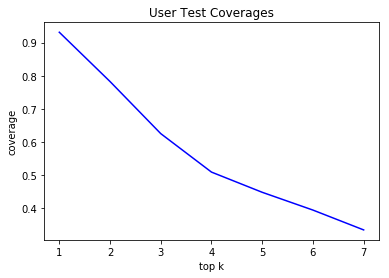

In [172]:
plt.figure()
plt.plot(k, user_covs_hybrid, c="b")
plt.title("User Test Coverages")
plt.xlabel('top k')
plt.ylabel('coverage')
plt.show()

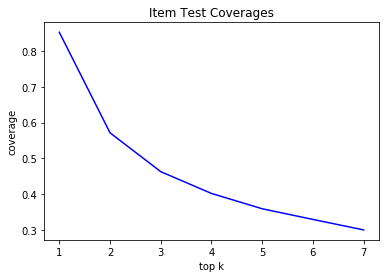

In [173]:
plt.figure()
plt.plot(k, item_covs_hybrid, c="b")
plt.title("Item Test Coverages")
plt.xlabel('top k')
plt.ylabel('coverage')
plt.show()

The user/item test coverages are doing better than the individual models itself. When compared against the same graphs under the matrix factorization model, as k increases to 7, the user/item coverage drop to 0.1, whereas in this case it drops to 0.3. 

#### NDCG

In [181]:
avg_ndcg_hybrid = ndcg_at_k(overall_results)
print("Average NDCG @ 10:", avg_ndcg_hybrid)

Average NDCG @ 10: 0.8604598231283402


## Overall Evaluation Results

| Model | RMSE | Prec@10 | Recall@10 | User Cov@10 | Item Cov@10 | NDCG@10
| --- | --- | --- | --- | --- | --- | --- | 
| Baseline | 0.921 | 0.653 | 0.542 | 0.933 | 0.826 | 0.861 |
| Collaborative Filtering Baseline | 0.867 | 0.685 | 0.564 | 0.933 | 0.810 | 0.872 |
| Content Based Model | 1.070 | 0.445 | 0.487 | 0.771 | 0.773 | 0.926 |
| Matrix Factorization | 0.989 | 0.577 | 0.472 | 0.933 | 0.835 | 0.923 |
| Deep Learning Model | 0.849 | 0.807 | 0.394 | 0.998 | 0.874 | 0.744 |
| Hybrid Model | 0.875 | 0.629 | 0.465 | 0.931 | 0.852 | 0.860 |

The above table represents all the methods we have in this project. The main three we are comparing is the 2 baselines (baseline and CF) and Hybrid model. We want to minimize RMSE and maximize the other matrics. From an initial glance of the results, we see that the first baseline of just utilizing average ratings of the movie and user produces really good results. In fact, our hybrid model only significantly beats that baseline in RMSE. The other metrics are approximately the same between the two methods. Compared to the CF Baseline, the hybrid model is unfortunately weaker on all aspects except item coverage. When looking at the performances of all the individual models, out of content based, matrix factorization, and deep learning, the deep learning model performs the best. This makes sense because the deep learning model had the most amount of information on its users, and therefore, was able to predict the most accuractely, having the lowest RMSE, highest user and item coverage, and also having a very high precision in comparison to the rest of the models. The surprising factor was its NDCG, it wasn't able to predict as ideal of a top 10 recommendation as other models. 

Taking a step back, we noticed that our hybrid model was not able to do better than our collaborative filtering baseline model. However, this result is not all negative because we can analyze the different models we use in our hybrid approach and know how to improve the model vastly. In comparison, the method we used to improve the baseline is not as flexible to improvement even with the gathering of new data. One possible reason why the Baseline outperforms our model is that it generalizes users. There is already a lot of information behind a users average rating and a movies average rating that is indicative of how this user will perceive that particular movie. In fact, most users give similar scores to movies. We set a "good recommendation" as a rating of over 3.5 which is quite a low bar. Most users would not constantly give super low ratings and most movies do not have incredibly low ratings. They will likely average around 3 to 4. We can see through the lower RMSE score in our hybrid model, it does do better in predicting the exact rating. If we divide the analysis more narrowly beyond "good" or "bad" recommendations, our hybrid model will likely outperform the baseline. This is also very applicable to the real world setting because a user's feeling towards a movie is not just 2 fold.

There are many ways we can improve our hybrid model to evetually completely outperform the baseline. Since we seperated our customers into three groups with three different models, we can analyze each individually to see where we can focus on. The content based model targets new users who do not have many rating data on the platform. It is also the weakest model among the three in our hybrid system. However, this can be vastly improved if we gather more data for each user and use that context as well. Currently, we can only use genre as our content for each user. If we include user profile information, we would have a lot more leeway for our content based recommendation. It would be incredibly helpful if the company can output a survey to solve the cold start issue and understand what a particular user would enjoy to watch.

The matrix factorization model is currently used to target customers who have a certain number of ratings. The model by itself is somewhat weak and would work better in conjunction with other models together. The deep learning model has the lowest RMSE but suffers in recall and NDCG. But it has very high precision in compared to the other models. This means the model is good at differentiating between a good and bad recommendation which is reasonable due to the good RMSE score. Recall is quite low for all the models and we will target that issue later. The low NDCG suggests that the model is not very good at ranking the relevant items highly. One possibility of this would be that the deep learning model does not always recommend popular items highly while the other models do. Therefore the other models have a higher score because it always recommends the popular items. Though people do enjoy popular movies, it does create an echo chamber which may not be what the platform would want. 

In conclusion, even though the hybrid model seems to not work too much better than the baselines, there is a lot more room for improvement for the hybrid model. The way we defiened "relevant" versus "irrelevant" recommendations may have been too relaxed which allowed the baseline model to superficially outperform the hybrid model.

## Final Recommendation

We recommend to gather more content based data for each user to better recommend movies to the new users. This would not only benefit new user retention, but also provide better analysis for other types of users as well. Furthermore, if computing power permits, we recommend creating ensemble methods within the hybrid model to give better predictions. In this case, each type of user will have a weighted hybrid model, in which several models would run in parallel and their recommendation outputs could be combined together with a weighting mechanism. Finally, we recommend referring to a domain specialist to define the proper way to split up ratings to what we can consider "relevant" versus "non-relevant".

In the future, we can take a closer look at controlling popularity recommendations to improve item coverage. However, this would unevitably decrease the scores for other metrics because people do rate popular movies higher. Therefore, there may be a better method of analzying whether or not a user truly enjoyed the experience of using the platform beyond just ratings. Some examples would be analyzing how much more the user started using the service or if they recommended the platform to other friends. A result of including these recommendations and future directions can enhance user experience and satisfaction, resulting in happier customers and more awareness and revenue for our platform. 